In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from torchinfo import summary
from pytorch.torchvision import save_model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_dir = "../data/chest_xray/train/"
test_dir = "../data/chest_xray/test/"

In [4]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.ColorJitter(),
    transforms.RandomRotation(degrees=15),
])

In [5]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 5232
     Root location: ../data/chest_xray/train/
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
            ),
 Dataset ImageFolder
     Number of datapoints: 624
     Root location: ../data/chest_xray/test/
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
 

In [6]:
class_names = train_data.classes
class_names

['NORMAL', 'PNEUMONIA']

In [7]:
class_dict = train_data.class_to_idx
class_dict

{'NORMAL': 0, 'PNEUMONIA': 1}

In [8]:
batch_size = 32

In [9]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1ca1113f8e0>,
 <torch.utils.data.dataloader.DataLoader at 0x1ca76045c40>)

In [10]:
class pneumoniav0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.conv2d_1 = nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1)
        self.conv2d_2 = nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1)
        self.conv2d_3 = nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*3, kernel_size=3, stride=1, padding=1)
        self.conv2d_4 = nn.Conv2d(in_channels=hidden_units*3, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1)
        self.maxpool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(in_features=hidden_units*4*(16*16), out_features=output_shape)

    def forward(self, x):

        z = self.conv2d_1(x)
        z = self.relu(z)
        z = self.conv2d_2(z)
        z = self.relu(z)
        z = self.maxpool_1(z)
        z = self.conv2d_3(z)
        z = self.relu(z)
        z = self.conv2d_4(z)
        z = self.relu(z)
        z = self.maxpool_1(z)
        z = self.flatten(z)
        z = self.linear_1(z)

        return z

In [11]:
model_0 = pneumoniav0(input_shape=3,
                      hidden_units=20,
                      output_shape=1).to(device)
model_0

pneumoniav0(
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv2d_1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_3): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_4): Conv2d(60, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=20480, out_features=1, bias=True)
)

In [12]:
summary(model_0, input_size=[32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
pneumoniav0                              [32, 1]                   --
├─Conv2d: 1-1                            [32, 20, 64, 64]          560
├─ReLU: 1-2                              [32, 20, 64, 64]          --
├─Conv2d: 1-3                            [32, 40, 64, 64]          7,240
├─ReLU: 1-4                              [32, 40, 64, 64]          --
├─MaxPool2d: 1-5                         [32, 40, 32, 32]          --
├─Conv2d: 1-6                            [32, 60, 32, 32]          21,660
├─ReLU: 1-7                              [32, 60, 32, 32]          --
├─Conv2d: 1-8                            [32, 80, 32, 32]          43,280
├─ReLU: 1-9                              [32, 80, 32, 32]          --
├─MaxPool2d: 1-10                        [32, 80, 16, 16]          --
├─Flatten: 1-11                          [32, 20480]               --
├─Linear: 1-12                           [32, 1]                   20,481

In [13]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [14]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [15]:
torch.manual_seed(42)

epochs = 10

for epoch in range(epochs):

    # training

    train_loss = 0
    train_acc = 0

    for batch, (X, y) in enumerate(train_dataloader):

        X = X.to(device)
        y = y.to(device)

        y = y.float()

        model_0.train()

        train_pred = model_0(X).squeeze()

        loss = loss_fn(train_pred, y)
        train_loss += loss

        acc = accuracy_fn(y_true=y,
                          y_pred=torch.round(torch.sigmoid(train_pred)))
        train_acc += acc

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # testing

    test_loss = 0
    test_acc = 0

    model_0.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:

            X = X.to(device)
            y = y.to(device)

            y = y.float()

            test_pred = model_0(X).squeeze()

            loss = loss_fn(test_pred, y)
            test_loss += loss

            acc = accuracy_fn(y_true=y,
                              y_pred=torch.round(torch.sigmoid(test_pred)))
            test_acc += acc

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}%")



Train loss: 0.56353 | Train accuracy: 74.58079% | Test loss: 0.64783 | Test accuracy: 63.43750%

Train loss: 0.40215 | Train accuracy: 81.87881% | Test loss: 0.40952 | Test accuracy: 81.09375%

Train loss: 0.29295 | Train accuracy: 88.62424% | Test loss: 0.59429 | Test accuracy: 77.50000%

Train loss: 0.20291 | Train accuracy: 91.52058% | Test loss: 0.36577 | Test accuracy: 83.43750%

Train loss: 0.17420 | Train accuracy: 92.96875% | Test loss: 0.39487 | Test accuracy: 84.37500%

Train loss: 0.16351 | Train accuracy: 93.73095% | Test loss: 0.87285 | Test accuracy: 74.37500%

Train loss: 0.13611 | Train accuracy: 94.79802% | Test loss: 0.42098 | Test accuracy: 84.68750%

Train loss: 0.13318 | Train accuracy: 94.83613% | Test loss: 0.58416 | Test accuracy: 82.65625%

Train loss: 0.12760 | Train accuracy: 94.96951% | Test loss: 0.65214 | Test accuracy: 78.43750%

Train loss: 0.11606 | Train accuracy: 95.29345% | Test loss: 0.83825 | Test accuracy: 78.43750%


In [16]:
save_model.save_model(model=model_0,target_dir="models",model_name="pneumonialungs_model_0.pth")

[INFO] Saving model to: models\pneumonialungs_model_0.pth


In [17]:
class pneumoniav1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.conv2d_1 = nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1)
        self.conv2d_2 = nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1)
        self.conv2d_3 = nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*3, kernel_size=3, stride=1, padding=1)
        self.conv2d_4 = nn.Conv2d(in_channels=hidden_units*3, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1)
        self.conv2d_5 = nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*5, kernel_size=3, stride=1, padding=1)
        self.maxpool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(in_features=hidden_units*5*(16*16), out_features=output_shape)

    def forward(self, x):

        z = self.conv2d_1(x)
        z = self.relu(z)
        z = self.conv2d_2(z)
        z = self.relu(z)
        z = self.maxpool_1(z)
        z = self.conv2d_3(z)
        z = self.relu(z)
        z = self.conv2d_4(z)
        z = self.relu(z)
        z = self.maxpool_1(z)
        z = self.conv2d_5(z)
        z = self.relu(z)
        z = self.flatten(z)
        z = self.linear_1(z)

        return z

In [18]:
model_1 = pneumoniav1(input_shape=3,
                      hidden_units=20,
                      output_shape=1).to(device)
model_1

pneumoniav1(
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv2d_1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_3): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_4): Conv2d(60, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_5): Conv2d(80, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=25600, out_features=1, bias=True)
)

In [19]:
summary(model_1, input_size=[32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
pneumoniav1                              [32, 1]                   --
├─Conv2d: 1-1                            [32, 20, 64, 64]          560
├─ReLU: 1-2                              [32, 20, 64, 64]          --
├─Conv2d: 1-3                            [32, 40, 64, 64]          7,240
├─ReLU: 1-4                              [32, 40, 64, 64]          --
├─MaxPool2d: 1-5                         [32, 40, 32, 32]          --
├─Conv2d: 1-6                            [32, 60, 32, 32]          21,660
├─ReLU: 1-7                              [32, 60, 32, 32]          --
├─Conv2d: 1-8                            [32, 80, 32, 32]          43,280
├─ReLU: 1-9                              [32, 80, 32, 32]          --
├─MaxPool2d: 1-10                        [32, 80, 16, 16]          --
├─Conv2d: 1-11                           [32, 100, 16, 16]         72,100
├─ReLU: 1-12                             [32, 100, 16, 16]         --

In [20]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [21]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [22]:
torch.manual_seed(42)

epochs = 10

for epoch in range(epochs):

    # training

    train_loss = 0
    train_acc = 0

    for batch, (X, y) in enumerate(train_dataloader):

        X = X.to(device)
        y = y.to(device)

        y = y.float()

        model_1.train()

        train_pred = model_1(X).squeeze()

        loss = loss_fn(train_pred, y)
        train_loss += loss

        acc = accuracy_fn(y_true=y,
                          y_pred=torch.round(torch.sigmoid(train_pred)))
        train_acc += acc

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # testing

    test_loss = 0
    test_acc = 0

    model_1.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:

            X = X.to(device)
            y = y.to(device)

            y = y.float()

            test_pred = model_1(X).squeeze()

            loss = loss_fn(test_pred, y)
            test_loss += loss

            acc = accuracy_fn(y_true=y,
                              y_pred=torch.round(torch.sigmoid(test_pred)))
            test_acc += acc

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}%")



Train loss: 0.57620 | Train accuracy: 74.02820% | Test loss: 0.66984 | Test accuracy: 63.43750%

Train loss: 0.55830 | Train accuracy: 74.54268% | Test loss: 0.65498 | Test accuracy: 63.43750%

Train loss: 0.70190 | Train accuracy: 74.18064% | Test loss: 0.67395 | Test accuracy: 63.43750%

Train loss: 0.57175 | Train accuracy: 74.18064% | Test loss: 0.68999 | Test accuracy: 63.43750%

Train loss: 0.62771 | Train accuracy: 73.89482% | Test loss: 0.74660 | Test accuracy: 63.43750%

Train loss: 0.57183 | Train accuracy: 74.25686% | Test loss: 0.68935 | Test accuracy: 63.43750%

Train loss: 0.57257 | Train accuracy: 74.16159% | Test loss: 0.67409 | Test accuracy: 63.43750%

Train loss: 0.57195 | Train accuracy: 74.19970% | Test loss: 0.68172 | Test accuracy: 63.43750%

Train loss: 0.57127 | Train accuracy: 74.21875% | Test loss: 0.68535 | Test accuracy: 63.43750%

Train loss: 0.57045 | Train accuracy: 74.27591% | Test loss: 0.69256 | Test accuracy: 63.43750%


In [23]:
save_model.save_model(model=model_1,target_dir="models",model_name="pneumonialungs_model_1.pth")

[INFO] Saving model to: models\pneumonialungs_model_1.pth


In [24]:
class pneumoniav2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.conv2d_1 = nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1)
        self.conv2d_2 = nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1)
        self.conv2d_3 = nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*3, kernel_size=3, stride=1, padding=1)
        self.conv2d_4 = nn.Conv2d(in_channels=hidden_units*3, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1)
        self.conv2d_5 = nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*5, kernel_size=3, stride=1, padding=1)
        self.conv2d_6 = nn.Conv2d(in_channels=hidden_units*5, out_channels=hidden_units*6, kernel_size=3, stride=1, padding=1)
        self.maxpool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(in_features=hidden_units*6*(8*8), out_features=output_shape)

    def forward(self, x):

        z = self.conv2d_1(x)
        z = self.relu(z)
        z = self.conv2d_2(z)
        z = self.relu(z)
        z = self.maxpool_1(z)
        z = self.conv2d_3(z)
        z = self.relu(z)
        z = self.conv2d_4(z)
        z = self.relu(z)
        z = self.maxpool_1(z)
        z = self.conv2d_5(z)
        z = self.relu(z)
        z = self.conv2d_6(z)
        z = self.relu(z)
        z = self.maxpool_1(z)
        z = self.flatten(z)
        z = self.linear_1(z)

        return z

In [25]:
model_2 = pneumoniav2(input_shape=3,
                      hidden_units=30,
                      output_shape=1).to(device)
model_2

pneumoniav2(
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv2d_1): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_2): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_3): Conv2d(60, 90, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_4): Conv2d(90, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_5): Conv2d(120, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_6): Conv2d(150, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=11520, out_features=1, bias=True)
)

In [26]:
summary(model_2, input_size=[32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
pneumoniav2                              [32, 1]                   --
├─Conv2d: 1-1                            [32, 30, 64, 64]          840
├─ReLU: 1-2                              [32, 30, 64, 64]          --
├─Conv2d: 1-3                            [32, 60, 64, 64]          16,260
├─ReLU: 1-4                              [32, 60, 64, 64]          --
├─MaxPool2d: 1-5                         [32, 60, 32, 32]          --
├─Conv2d: 1-6                            [32, 90, 32, 32]          48,690
├─ReLU: 1-7                              [32, 90, 32, 32]          --
├─Conv2d: 1-8                            [32, 120, 32, 32]         97,320
├─ReLU: 1-9                              [32, 120, 32, 32]         --
├─MaxPool2d: 1-10                        [32, 120, 16, 16]         --
├─Conv2d: 1-11                           [32, 150, 16, 16]         162,150
├─ReLU: 1-12                             [32, 150, 16, 16]         

In [27]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [28]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [29]:
torch.manual_seed(42)

epochs = 10

for epoch in range(epochs):

    # training

    train_loss = 0
    train_acc = 0

    for batch, (X, y) in enumerate(train_dataloader):

        X = X.to(device)
        y = y.to(device)

        y = y.float()

        model_2.train()

        train_pred = model_2(X).squeeze()

        loss = loss_fn(train_pred, y)
        train_loss += loss

        acc = accuracy_fn(y_true=y,
                          y_pred=torch.round(torch.sigmoid(train_pred)))
        train_acc += acc

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # testing

    test_loss = 0
    test_acc = 0

    model_2.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:

            X = X.to(device)
            y = y.to(device)

            y = y.float()

            test_pred = model_2(X).squeeze()

            loss = loss_fn(test_pred, y)
            test_loss += loss

            acc = accuracy_fn(y_true=y,
                              y_pred=torch.round(torch.sigmoid(test_pred)))
            test_acc += acc

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}%")



Train loss: 0.69387 | Train accuracy: 25.74314% | Test loss: 0.69355 | Test accuracy: 36.56250%

Train loss: 0.69387 | Train accuracy: 25.81936% | Test loss: 0.69354 | Test accuracy: 36.56250%

Train loss: 0.69387 | Train accuracy: 25.78125% | Test loss: 0.69354 | Test accuracy: 36.56250%

Train loss: 0.69387 | Train accuracy: 25.81936% | Test loss: 0.69354 | Test accuracy: 36.56250%

Train loss: 0.69387 | Train accuracy: 25.76220% | Test loss: 0.69354 | Test accuracy: 36.56250%

Train loss: 0.69387 | Train accuracy: 25.74314% | Test loss: 0.69354 | Test accuracy: 36.56250%

Train loss: 0.69387 | Train accuracy: 25.83841% | Test loss: 0.69354 | Test accuracy: 36.56250%

Train loss: 0.69387 | Train accuracy: 25.80030% | Test loss: 0.69355 | Test accuracy: 36.56250%

Train loss: 0.69387 | Train accuracy: 25.78125% | Test loss: 0.69354 | Test accuracy: 36.56250%

Train loss: 0.69388 | Train accuracy: 25.72409% | Test loss: 0.69354 | Test accuracy: 36.56250%


In [30]:
save_model.save_model(model=model_2,target_dir="models",model_name="pneumonialungs_model_2.pth")

[INFO] Saving model to: models\pneumonialungs_model_2.pth


In [31]:
import matplotlib.pyplot as plt
from typing import List
import torchvision

In [32]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
   
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    target_image = target_image / 255.0

    if transform:
        target_image = transform(target_image)

    model.to(device)

    model.eval()
    with torch.inference_mode():
        
        target_image = target_image.unsqueeze(dim=0)

        
        target_image_pred = model(target_image.to(device))

    
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)


In [37]:
import torch

In [38]:
torch.load("./models/pneumonialungs_model_0.pth")

OrderedDict([('conv2d_1.weight',
              tensor([[[[-0.1663,  0.0978,  0.1868],
                        [-0.0173, -0.0667, -0.0919],
                        [ 0.1781,  0.0908, -0.0791]],
              
                       [[ 0.1466, -0.0723,  0.0733],
                        [ 0.1478, -0.0167, -0.1182],
                        [ 0.0247, -0.0933,  0.1241]],
              
                       [[ 0.0486, -0.0738, -0.0746],
                        [-0.0660,  0.1325, -0.0413],
                        [-0.0227, -0.0463, -0.1028]]],
              
              
                      [[[ 0.1203,  0.0268, -0.0419],
                        [-0.1720, -0.0633,  0.0588],
                        [ 0.1181, -0.0795, -0.0717]],
              
                       [[ 0.0920,  0.1016,  0.1028],
                        [ 0.1258,  0.0123,  0.0462],
                        [ 0.0581, -0.0868,  0.0330]],
              
                       [[ 0.1946,  0.2036, -0.1243],
                       

In [46]:
model_test = pneumoniav0(input_shape=3,
                         hidden_units=20,
                         output_shape=1).to(device)

In [47]:
model_test.load_state_dict(torch.load("./models/pneumonialungs_model_0.pth"))

<All keys matched successfully>

In [82]:
summary(model_test,[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
pneumoniav0                              [1, 1]                    --
├─Conv2d: 1-1                            [1, 20, 64, 64]           560
├─ReLU: 1-2                              [1, 20, 64, 64]           --
├─Conv2d: 1-3                            [1, 40, 64, 64]           7,240
├─ReLU: 1-4                              [1, 40, 64, 64]           --
├─MaxPool2d: 1-5                         [1, 40, 32, 32]           --
├─Conv2d: 1-6                            [1, 60, 32, 32]           21,660
├─ReLU: 1-7                              [1, 60, 32, 32]           --
├─Conv2d: 1-8                            [1, 80, 32, 32]           43,280
├─ReLU: 1-9                              [1, 80, 32, 32]           --
├─MaxPool2d: 1-10                        [1, 80, 16, 16]           --
├─Flatten: 1-11                          [1, 20480]                --
├─Linear: 1-12                           [1, 1]                    20,481

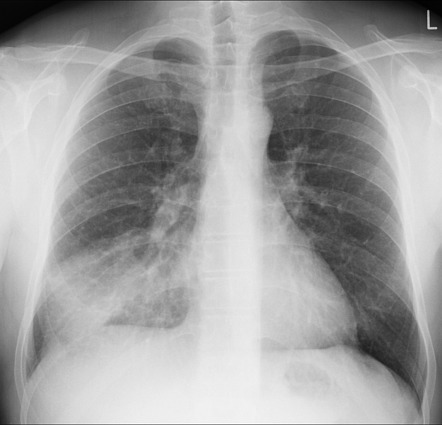

In [86]:
from PIL import Image
img = Image.open("../1.jpeg")
img


In [89]:
plt.imread("../1.jpeg")

array([[ 8,  8,  8, ...,  4,  3,  3],
       [10, 10, 10, ...,  5,  4,  4],
       [10, 10, 10, ...,  5,  5,  5],
       ...,
       [31, 37, 42, ..., 81, 71, 66],
       [32, 38, 43, ..., 85, 78, 72],
       [21, 23, 26, ..., 50, 46, 42]], dtype=uint8)

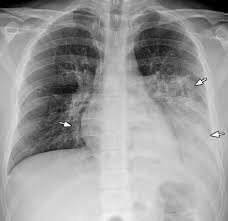

In [91]:
Image.open("../2.jpg")

In [92]:
plt.imread("../2.jpg")

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  2,   2,   2],
        [  1,   1,   1],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  3,   3,   3],
        [  2,   2,   2],
        [  1,   1,   1],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[140, 140, 140],
        [143, 143, 143],
        [141, 141, 141],
        ...,
        [142, 142, 142],
        [138, 138, 138],
        [135, 135, 135]],

       [[140, 140, 140],
        [143, 143, 143],
        [141, 141, 141],
        ...,
        [142, 142, 142],
        [138, 138, 138],
        [134, 134, 134]],

       [[140, 140, 140],
        [143, 143, 143],
        [141, 141, 141],
        ...,
        [141, 141, 141],
        [137, 137, 137],
        [134, 134, 134]]

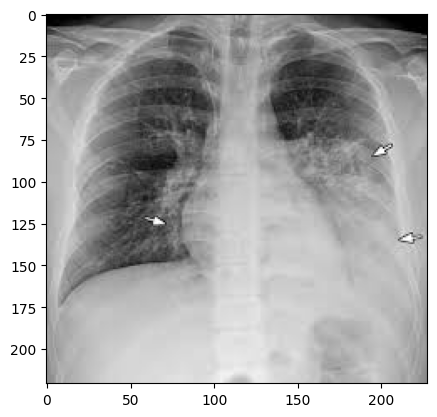

In [94]:
img = plt.imread("../2.jpg")
plt.imshow(img)

In [95]:
img.shape

(221, 228, 3)

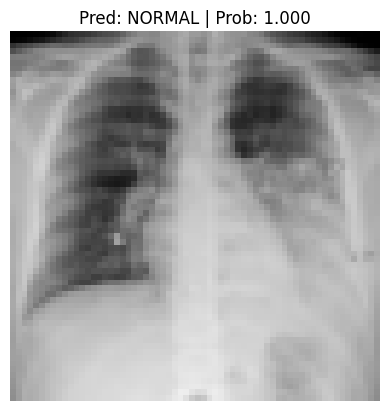

In [103]:
pred_and_plot_image(model=model_test,
                    image_path="../2.jpg",
                    class_names=class_names,
                    # transform=data_transform,
                    transform=transforms.Resize(size=(64, 64),antialias=True),
                    device=device)